In [2]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from scipy import stats
from rfpimp import plot_corr_heatmap
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
import statsmodels.api as sm
# from apyori import apriori
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv('./data/supermarket_sales - Sheet1.csv')

# 確認缺失值
df.isnull().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

###### 翻譯參考

In [4]:
# 中文參照
col_ref = {
    'Invoice ID': '發票編號',
    'Branch': '分店',
    'City': '城市',
    'Customer type': '顧客類型',
    'Gender': '性別',
    'Product line': '產品線',
    'Unit price': '單價',
    'Quantity': '數量',
    'Tax 5%': '稅金5%',
    'Total': '含稅金額',
    'Date': '日期',
    'Time': '時間',
    'Payment': '付款方式',
    'cogs': '銷售成本',
    'gross margin percentage': '毛利率百分比',
    'gross income': '毛利收入',
    'Rating': '評分'
}
Products = {'Fashion accessories': '流行產品',
'Food and beverages': '食品和飲料',
'Electronic accessories': '3C產品',
'Sports and travel': '運動和旅行',
'Home and lifestyle': '家庭與生活產品',
'Health and beauty': '健康和美容'}

Cities = {
    'Mandalay': '曼德勒',
    'Naypyitaw': '奈比多',
    'Yangon': '仰光'
}

Payments = {
    'Ewallet': '電子支付',
    'Cash': '現金',
    'Credit card': '信用卡'
}

In [5]:
chdata = df.copy()
chdata['Product line'] = chdata['Product line'].apply(lambda x: Products[x])
chdata['City'] = chdata['City'].apply(lambda x: Cities[x])
chdata['Payment'] = chdata['Payment'].apply(lambda x: Payments[x])
chdata.rename(columns=col_ref, inplace=True)
chdata.head()

,發票編號,分店,城市,顧客類型,性別,產品線,單價,數量,稅金5%,含稅金額,日期,時間,付款方式,銷售成本,毛利率百分比,毛利收入,評分
0,750-67-8428,A,仰光,Member,Female,健康和美容,74.69,7,26.1415,548.9715,1/5/2019,13:08,電子支付,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,奈比多,Normal,Female,3C產品,15.28,5,3.8200,80.2200,3/8/2019,10:29,現金,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,仰光,Normal,Male,家庭與生活產品,46.33,7,16.2155,340.5255,3/3/2019,13:23,信用卡,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,仰光,Member,Male,健康和美容,58.22,8,23.2880,489.0480,1/27/2019,20:33,電子支付,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,仰光,Normal,Male,運動和旅行,86.31,7,30.2085,634.3785,2/8/2019,10:37,電子支付,604.17,4.761905,30.2085,5.3


#### EDA
* 為了後續操作方便，先分類為數值化和非數值化

In [6]:
# 數值化分類
numerical_df = df.select_dtypes(include=np.number)
nonnumerical_df = df.select_dtypes(exclude=np.number)
num_cols = numerical_df.columns.to_list()
nonnum_cols = nonnumerical_df.columns.to_list()

In [7]:
# 城市偏好產品
df.groupby(['City', 'Product line']).size().unstack(fill_value=0)

Product line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
City,,,,,,
Mandalay,55,62,50,53,50,62
Naypyitaw,55,65,66,52,45,45
Yangon,60,51,58,47,65,59


城市偏好概覽，不適合計次比較，後續採聚合條件依照頻率排序

In [8]:
# 消費支付關係
PayProFrequency = df.groupby(['City', 'Payment', 'Product line']).size()\
    .reset_index(name = 'Frequency')\
    .sort_values(['City', 'Payment', 'Frequency', 'Product line'], \
                 ascending=False)
PayProFrequency.head(10)

,City,Payment,Product line,Frequency
52,Yangon,Ewallet,Home and lifestyle,26
53,Yangon,Ewallet,Sports and travel,23
49,Yangon,Ewallet,Fashion accessories,21
48,Yangon,Ewallet,Electronic accessories,21
50,Yangon,Ewallet,Food and beverages,19
51,Yangon,Ewallet,Health and beauty,16
44,Yangon,Credit card,Food and beverages,21
42,Yangon,Credit card,Electronic accessories,21
43,Yangon,Credit card,Fashion accessories,17
47,Yangon,Credit card,Sports and travel,16


In [9]:
# 各城市產品消費頻率
ProFrequency = PayProFrequency.groupby(['City', 'Product line'])\
    .agg({'Frequency': 'sum'}).sort_values(['City', 'Frequency', 'Product line'], \
        ascending=False)
ProFrequency.head(10)

Frequency
City      Product line                     
Yangon    Home and lifestyle             65
          Electronic accessories         60
          Sports and travel              59
          Food and beverages             58
          Fashion accessories            51
          Health and beauty              47
Naypyitaw Food and beverages             66
          Fashion accessories            65
          Electronic accessories         55
          Health and beauty              52

* 仰光的消費者熱愛家庭與生活產品，曼德勒和奈比多兩城市的家庭與生活產品則墊底
* 曼德勒和奈比多兩城市喜好流行產品，仰光對流行品依賴度墊底
* 奈比多喜歡買食品和飲料，曼德勒對食品和飲料興趣最低

In [10]:
# 各城市支付頻率
PayFrequency = PayProFrequency.groupby(['City', 'Payment'])\
    .agg({'Frequency': 'sum'}).sort_values(['City', 'Frequency', 'Payment'], \
        ascending=False)
PayFrequency.head(10)

Frequency
City      Payment               
Yangon    Ewallet            126
          Cash               110
          Credit card        104
Naypyitaw Cash               124
          Ewallet            106
          Credit card         98
Mandalay  Ewallet            113
          Cash               110
          Credit card        109

* 信用卡已經很普及，但是在各城市使用頻率上均不及電子支付和現金

依照`分類型資料`探索`含稅金額`比例，超過`十類`該分類不討論

In [11]:
# 各特徵依照含稅消費比例視覺化
# Total price including tax
goal = 'Total'
for i in range(nonnumerical_df.shape[1]):
    col = nonnumerical_df.iloc[:,[i]].columns[0]
    print('\n%s frequency: %s' % (col, dict(df[col].value_counts())))
    if len(df[[col]].value_counts(col)) > 10: continue
    print('%s(%s) Pie:' % (col, col_ref.get(col)))
    fig = px.pie(df[[col, goal]], values=goal, names=col
                 , width=400, height=300
                 )
    fig.show()


Invoice ID frequency: {'750-67-8428': 1, '642-61-4706': 1, '816-72-8853': 1, '491-38-3499': 1, '322-02-2271': 1, '842-29-4695': 1, '725-67-2480': 1, '641-51-2661': 1, '714-02-3114': 1, '518-17-2983': 1, '779-42-2410': 1, '190-14-3147': 1, '408-66-6712': 1, '679-22-6530': 1, '588-47-8641': 1, '576-31-4774': 1, '648-83-1321': 1, '556-41-6224': 1, '811-03-8790': 1, '242-11-3142': 1, '752-23-3760': 1, '274-05-5470': 1, '648-94-3045': 1, '130-67-4723': 1, '528-87-5606': 1, '320-85-2052': 1, '370-96-0655': 1, '105-10-6182': 1, '510-79-0415': 1, '241-96-5076': 1, '562-12-5430': 1, '250-81-7186': 1, '169-52-4504': 1, '133-77-3154': 1, '628-90-8624': 1, '856-66-2701': 1, '308-39-1707': 1, '149-61-1929': 1, '655-07-2265': 1, '589-02-8023': 1, '420-04-7590': 1, '182-88-2763': 1, '188-55-0967': 1, '610-46-4100': 1, '318-81-2368': 1, '364-33-8584': 1, '665-63-9737': 1, '695-09-5146': 1, '155-45-3814': 1, '794-32-2436': 1, '131-15-8856': 1, '273-84-2164': 1, '706-36-6154': 1, '778-89-7974': 1, '574


City frequency: {'Yangon': 340, 'Mandalay': 332, 'Naypyitaw': 328}
City(城市) Pie:



Customer type frequency: {'Member': 501, 'Normal': 499}
Customer type(顧客類型) Pie:



Gender frequency: {'Female': 501, 'Male': 499}
Gender(性別) Pie:



Product line frequency: {'Fashion accessories': 178, 'Food and beverages': 174, 'Electronic accessories': 170, 'Sports and travel': 166, 'Home and lifestyle': 160, 'Health and beauty': 152}
Product line(產品線) Pie:



Date frequency: {'2/7/2019': 20, '2/15/2019': 19, '3/14/2019': 18, '3/2/2019': 18, '1/8/2019': 18, '1/26/2019': 17, '1/25/2019': 17, '1/23/2019': 17, '3/5/2019': 17, '3/19/2019': 16, '2/25/2019': 16, '3/9/2019': 16, '1/19/2019': 16, '3/20/2019': 15, '2/3/2019': 14, '1/28/2019': 14, '2/2/2019': 14, '2/27/2019': 14, '1/31/2019': 14, '1/27/2019': 14, '3/3/2019': 14, '1/14/2019': 13, '2/6/2019': 13, '2/17/2019': 13, '1/24/2019': 13, '2/9/2019': 13, '3/26/2019': 13, '1/15/2019': 13, '2/5/2019': 12, '3/12/2019': 12, '1/29/2019': 12, '1/5/2019': 12, '1/1/2019': 12, '3/10/2019': 12, '3/15/2019': 12, '2/8/2019': 12, '3/4/2019': 12, '1/12/2019': 11, '3/11/2019': 11, '3/8/2019': 11, '3/6/2019': 11, '3/30/2019': 11, '3/24/2019': 11, '2/4/2019': 11, '2/22/2019': 11, '3/23/2019': 11, '1/17/2019': 11, '2/10/2019': 11, '1/13/2019': 10, '2/20/2019': 10, '3/22/2019': 10, '1/16/2019': 10, '3/13/2019': 10, '1/20/2019': 10, '3/27/2019': 10, '3/28/2019': 10, '3/1/2019': 10, '1/18/2019': 9, '1/30/2019': 9, 

* 三種支付方式對於收益貢獻相仿
* 食品和運動產品收益略高於其他產品，健康商品收益最差
* 奈比多收益略高於另外兩個城市
* 女性消費金額略高於男性

#### 特徵工程
0. 空值/重複特徵處理
1. 特徵縮放
2. 異常值偵測
3. 特徵提取
4. 特徵選擇

##### 0. 空值/重複特徵處理

In [12]:
# 發票編號可以假設為schema，不應重複
dup_flag = df['Invoice ID'].nunique() == df.shape[0]
null_flag = len({k: v for k, v in dict(df.isnull().sum()).items() if v != 0})
if dup_flag: print('不需要移除重複資料')
if not null_flag: print('不需要移除空值資料')

不需要移除重複資料
不需要移除空值資料


##### 1. 特徵縮放
基於常態分布，正規化後，將三倍標準差外視為異常值  
因為沒有任何異常值，故不額外處置

In [13]:
num_df = numerical_df.copy()
# Z score
num_df[num_cols] = StandardScaler().fit_transform(num_df)
# 或是直接計算
# num_df = (num_df - num_df.mean()) / num_df.std()

over_std3 = num_df[(num_df[num_cols] < -3) | (num_df[num_cols] > 3)].dropna(how='all')
if not len(over_std3): print('沒有錯誤異常值，不用刪除任何一筆資料')
over_std3.head()

沒有錯誤異常值，不用刪除任何一筆資料


,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating


##### 2. 異常值偵測
###### Pearson Correlation Matrix
可以看出'gross income', 'cogs', 'Total', 'Tax 5%'  
這四個欄位共變異數矩陣相同  
因為都是由收益金額計算而來  
所以會有相同的變異性以及相關性  
彼此四個特徵相關係數更是明顯可以看出  
數值接近為1.00  
做降維時，可以僅取一個特徵表之  
以便建立有效模型

In [14]:
# 評估是否為獨立且具有相同共變異數矩陣的特徵
# 基於Person計算共變異數矩陣
cov_matrix = np.cov(num_df.values.T)
pd.DataFrame(cov_matrix, columns=num_df.columns, index=num_df.columns.to_list())

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
Unit price,1.001001,0.010788,0.634597,0.634597,0.634597,0.0,0.634597,-0.008786
Quantity,0.010788,1.001001,0.706216,0.706216,0.706216,0.0,0.706216,-0.015831
Tax 5%,0.634597,0.706216,1.001001,1.001001,1.001001,0.0,1.001001,-0.036478
Total,0.634597,0.706216,1.001001,1.001001,1.001001,0.0,1.001001,-0.036478
cogs,0.634597,0.706216,1.001001,1.001001,1.001001,0.0,1.001001,-0.036478
gross margin percentage,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
gross income,0.634597,0.706216,1.001001,1.001001,1.001001,0.0,1.001001,-0.036478
Rating,-0.008786,-0.015831,-0.036478,-0.036478,-0.036478,0.0,-0.036478,1.001001


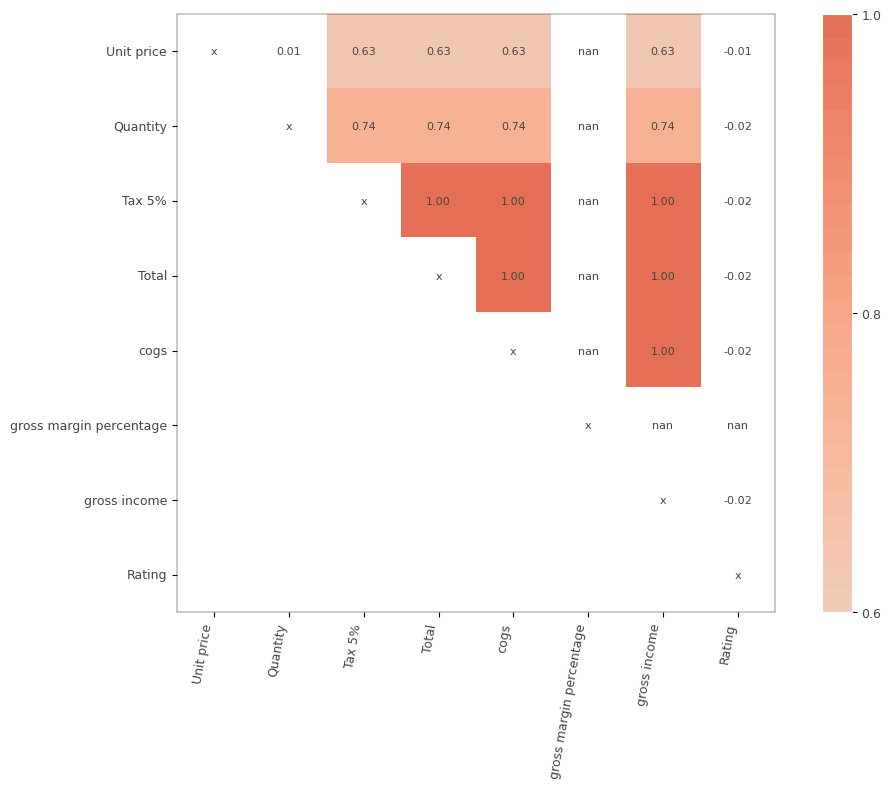

In [15]:
fig = plot_corr_heatmap(num_df, figsize=(12,8))
fig.view()

使用`allclose`取出具有相同共變異數矩陣的欄位  
相對公差與絕對公差均取預設

In [16]:
unique_cov_matrix = []
for i in range(cov_matrix.shape[0]):
    for j in range(i+1, cov_matrix.shape[1]):
        if np.allclose(cov_matrix[i], cov_matrix[j]):
            unique_cov_matrix.append((i, j))

unique_features = set()
for idx in unique_cov_matrix:
    unique_features.add(num_cols[idx[0]])
    unique_features.add(num_cols[idx[1]])

unique_features = list(unique_features)
print('%s 具有相同的共變異數矩陣' % (', '.join(unique_features)))

cogs, gross income, Tax 5%, Total 具有相同的共變異數矩陣


考慮rawdata中兩個特徵  
`Unit price`以及`gross margin percentage`  
由會計計算收益的方法推論  
```Bash
COGS = (Unit price) * Quantity
Tax 5% = COGS * 5/100
Total = COGS + Tax 5%
gross income = Total * (gross margin percentage)/100
```
取單筆數據驗算後可以得到符合知識的結果。  
`假設沒有這些知識`時，推論4筆特徵間有線性關係

In [17]:
# 判斷是否常數
print('Unit price:', num_df['Unit price'].nunique())
print('gross margin percentage:', num_df['gross margin percentage'].nunique())

Unit price: 943
gross margin percentage: 1


`gross income`(毛利收入)和`Total`(含稅金額)是常數關係  
這裡不使用正規化後的資料，取原始資料  
因判斷是線性關係，所以不進行Jacobian轉換  
直接使用最小二乘法來對上述4特徵擬合  
判斷是否可以找到同樣的線性關係

In [18]:
# 取有常數關係者為因變數
dep_var = 'gross income'
indep_var = unique_features.copy()
indep_var.remove(dep_var)
tup = []
for i in range(df[indep_var].values.ndim + 1):
    tup.append(df[indep_var].values[:,i])
X = np.column_stack(tup)
ols_model = sm.OLS(df[dep_var].values, X).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.038e+34
Date:                Fri, 21 Apr 2023   Prob (F-statistic):                        0.00
Time:                        00:15:13   Log-Likelihood:                          31329.
No. Observations:                1000   AIC:                                 -6.266e+04
Df Residuals:                     999   BIC:                                 -6.265e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

* Adj. R-squared前後都是1.0，沒有過擬合狀況，模型可以信任。
* 最小特徵值為1.45e-27。可能表示存在嚴重的多元共線性問題。  
* 下面評估計算Variance inflation factor

In [19]:
# 計算方差擴大因子(Variance inflation factor)
vif = 1 / (1 - ols_model.rsquared)
if vif > 10:
    print("%s 等特徵間存在多元共線性" % ', '.join(unique_features))
else:
    print("%s 等特徵間不存在多元共線性" % ', '.join(unique_features))

cogs, gross income, Tax 5%, Total 等特徵間存在多元共線性


上述計算後在一定程度上可以證明  
根據會計知識的推論公式符合該資料集的金額特徵關係  
特徵間的變異數可以互相解釋  
在未知的知識領域可以使用該法找到特徵間的關係

###### 離群值檢測
使用共變異數誤差橢圓，找出離群點，  
平均值取代異常值

In [20]:
# Detect outliers
envelope = EllipticEnvelope(contamination=0.01)
envelope.fit(num_df)
pred = envelope.predict(num_df)

# Figure outliers id
abnormal_id = np.where(pred == -1)
print('需要以平均值取代的index:', abnormal_id)

# 以特徵平均值取代異常值
for col in numerical_df.columns:
    col_mean = numerical_df[col].mean()
    numerical_df[col].iloc[abnormal_id] = col_mean

df_processed = pd.concat([numerical_df, nonnumerical_df], axis=1)
df_processed.tail()

需要以平均值取代的index: (array([118, 349, 368, 402, 443, 469, 493, 498, 656, 822], dtype=int64),)


,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating,Invoice ID,Branch,City,Customer type,Gender,Product line,Date,Time,Payment
995,40.35,1.0,2.0175,42.3675,40.35,4.761905,2.0175,6.2,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,1/29/2019,13:46,Ewallet
996,97.38,10.0,48.6900,1022.4900,973.80,4.761905,48.6900,4.4,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,3/2/2019,17:16,Ewallet
997,31.84,1.0,1.5920,33.4320,31.84,4.761905,1.5920,7.7,727-02-1313,A,Yangon,Member,Male,Food and beverages,2/9/2019,13:22,Cash
998,65.82,1.0,3.2910,69.1110,65.82,4.761905,3.2910,4.1,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,2/22/2019,15:33,Cash
999,88.34,7.0,30.9190,649.2990,618.38,4.761905,30.9190,6.6,849-09-3807,A,Yangon,Member,Female,Fashion accessories,2/18/2019,13:28,Cash


##### 3. 特徵提取

In [21]:
# 特徵提取
df_processed['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df_processed['Year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year
df_processed['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month
df_processed['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour
df_processed['Minute'] = pd.to_datetime(df['Time'], errors='coerce').dt.minute
print('Year frequency:', dict(df_processed['Year'].value_counts()))
print('Month frequency:', dict(df_processed['Month'].value_counts()))
df_processed[['Month', 'Date', 'Hour', 'Minute']].head()

Year frequency: {2019: 1000}
Month frequency: {1: 352, 3: 345, 2: 303}


,Month,Date,Hour,Minute
0,1,2019-01-05,13,8
1,3,2019-03-08,10,29
2,3,2019-03-03,13,23
3,1,2019-01-27,20,33
4,2,2019-02-08,10,37


##### 4. 特徵選擇
* 先選擇需要的特徵，再特徵轉換
* 採Target Encoding以評分為標的，處理非數值化資料的分類標籤
* 對包括分類型資料所有資料進行正規化

In [22]:
# 如前述，cogs等3項可以Total作為特徵描述；gross margin percentage是常數
encoder_df = df_processed.drop(['Invoice ID', 'Date', 'Time','cogs', 'gross income', 'Tax 5%', 'gross margin percentage'], axis=1)
encoder = ce.TargetEncoder(cols=['Gender', 'Product line', 'Payment', 'Branch', 'City', 'Customer type'])
encoder_df = encoder.fit_transform(encoder_df, encoder_df['Rating'])
encoder_df.head()

,Unit price,Quantity,Total,Rating,Branch,City,Customer type,Gender,Product line,Payment,Year,Month,Hour,Minute
0,74.69,7.0,548.9715,9.1,7.029920,7.029920,6.927272,6.962293,7.017583,6.935125,2019,1,13,8
1,15.28,5.0,80.2200,9.6,7.052771,7.052771,7.007542,6.962293,6.910267,6.967997,2019,3,10,29
2,46.33,7.0,340.5255,7.4,7.029920,7.029920,7.007542,6.972381,6.810909,7.002309,2019,3,13,23
3,58.22,8.0,489.0480,8.4,7.029920,7.029920,6.927272,6.972381,7.017583,6.935125,2019,1,20,33
4,86.31,7.0,634.3785,5.3,7.029920,7.029920,7.007542,6.972381,6.920591,6.935125,2019,2,10,37


In [23]:
SCALER = StandardScaler()
nor_df = encoder_df.copy()
SCALER.fit(nor_df)
nor_df[encoder_df.columns] = SCALER.transform(nor_df)
nor_df.head()

,Unit price,Quantity,Total,Rating,Branch,City,Customer type,Gender,Product line,Payment,Year,Month,Hour,Minute
0,0.721321,0.512943,0.914483,1.248476,0.595458,0.595458,-0.998002,-0.998002,0.512603,-1.184979,0.0,-1.189455,-0.599637,-1.309726
1,-1.552605,-0.179802,-1.002109,1.541178,0.812847,0.812847,1.002002,-0.998002,-0.581997,0.024637,0.0,1.206225,-1.541474,-0.065077
2,-0.364162,0.512943,0.062207,0.253289,0.595458,0.595458,1.002002,1.002002,-1.595425,1.287275,0.0,1.206225,-0.599637,-0.420691
3,0.090929,0.859316,0.669473,0.838693,0.595458,0.595458,-0.998002,1.002002,0.512603,-1.184979,0.0,-1.189455,1.597984,0.171999
4,1.166078,0.512943,1.263688,-0.976060,0.595458,0.595458,1.002002,1.002002,-0.476695,-1.184979,0.0,0.008385,-1.541474,0.409074


#### 模型預測
###### 定義問題
 * 依據評分`Rating`資料，由其他特徵對於評分進行預測  
    - 根據數據判斷，可以知道評分屬於連續型資料

In [24]:
df['Rating'].describe()

count    1000.00000
mean        6.97270
std         1.71858
min         4.00000
25%         5.50000
50%         7.00000
75%         8.50000
max        10.00000
Name: Rating, dtype: float64

取3成作為測試資料

In [25]:
y = nor_df['Rating']
X = nor_df.drop('Rating', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
RFR = RandomForestRegressor(n_jobs=4)
model = RFR

###### 十折交叉驗證調參數
可以看出結果並不好  
R2低於0，理論上可以放棄進行模型建置  
依照經驗，本資料集缺乏對於產品和服務的描述  
有回到資料蒐集層面重新檢討的必要  
以下繼續進行以示意為主

In [26]:
r2_scores = cross_val_score(RFR, X_train, y_train, scoring='r2', cv=10)
print("Cross-validated scores:", r2_scores)
print("Average score:", r2_scores.mean())

Cross-validated scores: [-0.0385406  -0.08913511 -0.06456693 -0.10826434 -0.14153895 -0.07977585
 -0.0592732  -0.18177692 -0.14471813 -0.15603079]
Average score: -0.10636208075202966


使用 GridSearchCV 選擇最佳參數組合

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 6]
}

grid_search = GridSearchCV(RFR, param_grid=param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 100}
Best score: -0.071221261734658


###### 模型性能
因為本資料為連續型資料，使用回歸指標

In [29]:
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2s = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE:", mse)
print("R2 Score:", r2s)
print("MAE:", mae)

corr = nor_df.corr()
fig = px.imshow(nor_df.corr(), labels=dict(color="Correlation"), color_continuous_scale='YlGnBu')
fig.show()

MSE: 1.1091500363202953
R2 Score: -0.0641713345628867
MAE: 0.8931682622329007


#### 模型IO驗證
使用*.pkl存取模型，驗證讀取後可以進行預測得到需要的評分資料  

In [30]:
filename = 'randomForestRegressor.pkl'
with open(filename, 'wb') as f:
    pickle.dump(grid_search, f)

In [31]:
RFR_load = None
with open(filename, 'rb') as f:
    RFR = pickle.load(f)
rfr_pred = RFR.predict(X_test)
RFR_inv = SCALER.inverse_transform(np.column_stack((X_test, rfr_pred)))[:, -1]
X_inv = SCALER.inverse_transform(np.column_stack((X_test, rfr_pred)))[:, :-1]
pred_df = pd.DataFrame(X_inv, columns=X_test.columns)
pred_df['Rating'] = RFR_inv
pred_df

,Unit price,Quantity,Total,Branch,City,Customer type,Gender,Product line,Payment,Year,Month,Hour,Minute,Rating
0,73.06,7.0,536.9910,4.553849,6.818811,7.072654,7.007542,6.975120,7.093534,6.967327,2017.810545,3.064961,10.360605,29.326658
1,27.00,9.0,255.1500,4.553849,6.818811,6.862420,7.007542,6.959280,6.969742,6.967327,2020.206225,1.754495,12.248478,30.414646
2,97.94,1.0,102.8370,7.984501,7.029920,7.072654,7.007542,6.959280,6.851150,6.967327,2020.206225,0.968215,17.534520,31.445323
3,16.28,1.0,17.0940,8.355850,7.052771,7.072654,7.007542,6.969780,6.969742,6.967327,2020.206225,2.016588,16.024222,33.222798
4,99.25,2.0,208.4250,4.553849,6.818811,7.072654,7.007542,6.969780,6.969742,6.967327,2020.206225,1.492402,9.605456,33.727721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,25.55,4.0,107.3100,4.553849,6.818811,7.072654,7.007542,6.959280,6.851150,6.967327,2017.810545,3.327055,13.569988,24.932802
296,55.87,10.0,586.6350,8.355850,7.052771,7.072654,7.007542,6.964391,6.969742,6.967327,2017.810545,2.016588,9.416669,31.266570
297,86.13,2.0,180.8730,8.355850,7.052771,7.072654,7.007542,6.969780,6.969742,6.967327,2019.008385,2.540775,20.366328,34.180232
298,25.90,10.0,271.9500,4.553849,6.818811,6.862420,7.007542,6.969912,6.851150,6.967327,2019.008385,1.754495,18.856031,31.145924
